# Florence-2: Open Source Vision Foundation Model
Florence-2 is a lightweight vision-language foundation model developed by Microsoft Azure AI and open-sourced under the MIT license. It aims to achieve a unified, prompt-based representation for diverse vision and vision-language tasks, including captioning, object detection, grounding, and segmentation. Despite its compact size, Florence-2 rivals much larger models like Kosmos-2 in performance. Florence-2 represents a significant advancement in vision-language models by combining lightweight architecture with robust capabilities, making it highly accessible and versatile. Its unified representation approach, supported by the extensive FLD-5B dataset, enables it to excel in multiple vision tasks without the need for separate models. This efficiency makes Florence-2 a strong contender for real-world applications, particularly on devices with limited resources.
# Paper 
https://arxiv.org/pdf/2311.06242
# Models
https://huggingface.co/microsoft/Florence-2-large
# Dataset
Training set (FLD-5B) of 126M images, more than 500M text annotations, 1.3B region-text annotations, and 3.6B textphrase-region annotations. Each image is annotated with text, region-text pairs, and text-phrase-region triplets and each annotation type has multiple instances varying in diverse granularity


# Openvino (Open Visual Inference and Neural network Optimization)
OpenVINO is an open-source toolkit for optimizing and deploying deep learning models from cloud to edge. It accelerates deep learning inference across various use cases, such as generative AI, video, audio, and language with models from popular frameworks like PyTorch, TensorFlow, ONNX, and more. Convert and optimize models, and deploy across a mix of Intel® hardware and environments, on-premises and on-device, in the browser or in the cloud.

- https://docs.openvino.ai/2024/index.html
- https://docs.openvino.ai/2024/documentation/openvino-ir-format.html (Intermediate Representation)
# MLFLOW

MLflow is an open-source platform, purpose-built to assist machine learning practitioners and teams in handling the complexities of the machine learning process. MLflow focuses on the full lifecycle for machine learning projects, ensuring that each phase is manageable, traceable, and reproducible.

https://mlflow.org/docs/latest/index.html

In [1]:
import platform

%pip install -q "openvino>=2024.3.0" "einops" "torch>2.1" "torchvision" "timm>=0.9.8" "transformers>=4.41" "pillow" "gradio>=4.19" --extra-index-url https://download.pytorch.org/whl/cpu

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
#! pip install mlflow ov_helpers -q

In [1]:
import requests
from pathlib import Path
import os

In [2]:


if not Path("ov_florence2_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/florence2/ov_florence2_helper.py")
    open("ov_florence2_helper.py", "w", encoding="utf-8").write(r.text)


if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/florence2/gradio_helper.py")
    open("gradio_helper.py", "w", encoding="utf-8").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w" ,encoding="utf-8").write(r.text)

In [3]:
from ov_helpers.ov_florence2_helper import convert_florence2, get_model_selector

model_selector = get_model_selector()

model_selector

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


Dropdown(description='Model:', options=('microsoft/Florence-2-base-ft', 'microsoft/Florence-2-base', 'microsof…

In [4]:
model_id = model_selector.value
model_path = Path(model_id.split("/")[-1])

# Uncomment the line to see conversion code
#??convert_florence2

In [5]:
convert_florence2(model_id, model_path)

✅ microsoft/Florence-2-base-ft already converted and can be found in Florence-2-base-ft


In [6]:
from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [7]:
from ov_helpers.ov_florence2_helper import OVFlorence2Model

In [8]:
modelp = os.path.join(os.getcwd(), model_path.name)
modelp

'D:\\repos\\openvino\\Florence2\\Florence-2-base-ft'

In [9]:
model = OVFlorence2Model(modelp, device.value)

In [10]:
import requests
from PIL import Image

from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)

prompt = "<OD>"

# url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
# image = Image.open(requests.get(url, stream=True).raw)
path = "../images/buildings.jpg"
image = Image.open(path)
#image

In [11]:
image.width

6720

In [12]:
#processor.image_processor.crop_size = {'height': 1024, 'width': 1024}

In [13]:
inputs = processor(text=prompt, images=image, return_tensors="pt")



In [14]:
#processor

In [15]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [16]:
inputs["pixel_values"].shape

torch.Size([1, 3, 768, 768])

In [17]:
inputs["input_ids"]

tensor([[    0,   574, 22486,     5,  8720,    19,  4120,   766,    11,     5,
          2274,     4,     2]])

In [18]:
generated_ids = model.generate(input_ids=inputs["input_ids"], pixel_values=inputs["pixel_values"], max_new_tokens=1024, do_sample=False, num_beams=3)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

In [19]:
parsed_answer

{'<OD>': {'bboxes': [[3.359999895095825,
    2331.840087890625,
    6709.919921875,
    4473.27978515625],
   [3.359999895095825, 2842.56005859375, 6709.919921875, 4473.27978515625],
   [2772.0, 2318.39990234375, 4277.27978515625, 3666.880126953125],
   [4196.6396484375, 2703.679931640625, 4935.83984375, 3689.280029296875],
   [3.359999895095825, 2842.56005859375, 305.7599792480469, 3859.52001953125],
   [4888.7998046875, 3295.0400390625, 5439.83984375, 4473.27978515625],
   [3.359999895095825, 3321.919921875, 251.99998474121094, 4473.27978515625],
   [789.5999755859375, 4146.240234375, 944.1599731445312, 4473.27978515625],
   [2543.52001953125, 4052.159912109375, 2644.31982421875, 4312.0]],
  'labels': ['skyscraper',
   'skyscraper',
   'skyscraper',
   'skyscraper',
   'skyscraper',
   'street light',
   'street light',
   'street light',
   'street light']}}

In [20]:
import io
import copy
import random
import requests
from pathlib import Path

import gradio as gr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from PIL import Image, ImageDraw

In [21]:
def plot_bbox(image, data):
    fig, ax = plt.subplots()
    ax.imshow(image)
    for bbox, label in zip(data["bboxes"], data["labels"]):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        plt.text(x1, y1, label, color="white", fontsize=8, bbox=dict(facecolor="red", alpha=0.5))
    ax.axis("off")
    return fig

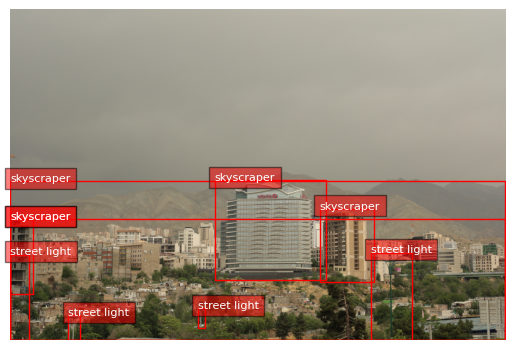

In [22]:
#from gradio_helper import plot_bbox

fig = plot_bbox(image, parsed_answer["<OD>"])

In [23]:
prompt = "<MORE_DETAILED_CAPTION>"
inputs = processor(text=prompt, images=image, return_tensors="pt")

In [24]:
generated_ids = model.generate(input_ids=inputs["input_ids"], pixel_values=inputs["pixel_values"], max_new_tokens=1024, do_sample=False, num_beams=3)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<MORE_DETAILED_CAPTION>", image_size=(image.width, image.height))

In [25]:
parsed_answer.get('<MORE_DETAILED_CAPTION>')

'This is an image of a city. The city is filled with buildings. The buildings are very tall. The building in the middle is made of glass and metal. The sky is gray and cloudy. There are mountains in the background. The mountains are brown and gray. The trees in the foreground are green and healthy. There is a street light by the buildings.'

In [26]:
from dotenv import load_dotenv
import os
from transformers.utils import logging
ROOT_DIR = os.getcwd()
load_dotenv(os.path.join(ROOT_DIR,".env"))

True

In [27]:
from dotenv import dotenv_values
import mlflow
config = dotenv_values(os.path.join(ROOT_DIR,".env"))

In [28]:
logging.set_verbosity_error()

os.environ["TRANSFORMERS_VERBOSITY"] = "error"

In [29]:
MLFLOW_TRACKING_URI=config.get('MLFLOW_TRACKING_URI')
# Specify the workspace hostname and token
DATABRICKS_HOST=config.get('DATABRICKS_HOST')
DATABRICKS_TOKEN=config.get('DATABRICKS_TOKEN')

In [30]:

os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI

os.environ["DATABRICKS_HOST"] = DATABRICKS_HOST

os.environ["DATABRICKS_TOKEN"] = DATABRICKS_TOKEN

In [31]:
os.environ["DATABRICKS_HOST"]

'https://adb-2467347032368999.19.azuredatabricks.net/'

In [32]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [ ]:
mlflow.set_experiment(f"{config.get('USER_DATABRICKS')}/Florence2_captioning")

In [34]:
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.pyfunc import PythonModel
import pprint

In [35]:
os.getcwd()

'D:\\repos\\openvino\\Florence2'

In [36]:
class Florence2_Captioner(PythonModel):
  def load_context(self, context):
        """
        This method initializes the tokenizer and language model
        using the specified model snapshot directory.
        """
        from ov_helpers.ov_florence2_helper import OVFlorence2Model
        from transformers import AutoProcessor

        self.model = OVFlorence2Model(model_dir=context.artifacts["snapshot"], device="AUTO")
        self.processor =  AutoProcessor.from_pretrained(context.artifacts["snapshot"], trust_remote_code=True)



  def predict(self, context, model_input, params=None):
        """
        This method generates prediction for the given input.
        """
        # Parameters
        task = params.get("task", '<MORE_DETAILED_CAPTION>') if params else '<MORE_DETAILED_CAPTION>'
        max_new_tokens = params.get("max_new_tokens", 1024) if params else 1024
        num_beams = params.get("num_beams", 3) if params else 3
        # get Image
        image_path  = model_input["path_image"][0]
        raw_image = Image.open(image_path).convert("RGB")
        # process image
        inputs = self.processor(text=task, images=raw_image, return_tensors="pt")
        # conditional image captioning
        generated_ids = self.model.generate(input_ids=inputs["input_ids"], pixel_values=inputs["pixel_values"], max_new_tokens=max_new_tokens, do_sample=False, num_beams=num_beams)
        generated_text = self.processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        
        parsed_answer = self.processor.post_process_generation(generated_text, task=task,image_size=(raw_image.width, raw_image.height))
        return  {task: [parsed_answer.get(task)]}

In [37]:
import numpy as np
import pandas as pd

import mlflow
from mlflow.models.signature import ModelSignature
from mlflow.types import ColSpec, DataType, ParamSchema, ParamSpec, Schema

from mlflow.models import infer_signature


# model_output= [{'<MORE_DETAILED_CAPTION>': """This is an image of a city. The city is filled with buildings. The buildings are very tall. The building in the middle is made of glass and metal.
# The sky is gray and cloudy. There are mountains in the background. The mountains are brown and gray. The trees in the foreground are green and healthy. There is a street light by 
# the buildings."""}]

model_output = Schema([ColSpec(DataType.string, "task")])

model_input = Schema(
    [
        ColSpec(DataType.string, "path_image"),
    ]
)
parameters = ParamSchema(
    [
        ParamSpec("temperature", DataType.float, np.float32(0.1), None),
        ParamSpec("max_new_tokens", DataType.integer, np.int32(1024), None),
        ParamSpec("num_beams", DataType.integer, np.int32(3), None),
        ParamSpec("task", DataType.string, "<MORE_DETAILED_CAPTION>", None),
    ]
)

signature = ModelSignature(inputs=model_input,outputs=model_output, params=parameters)

# Define input example

input_example = pd.DataFrame({"path_image": ["D:\\repos\\openvino\\images\\buildings.jpg"]})

In [38]:
signature

inputs: 
  ['path_image': string (required)]
outputs: 
  ['task': string (required)]
params: 
  ['temperature': float (default: 0.10000000149011612), 'max_new_tokens': integer (default: 1024), 'num_beams': integer (default: 3), 'task': string (default: <MORE_DETAILED_CAPTION>)]

In [39]:
import datetime
now = datetime.datetime.now()
now.strftime("%Y-%m-%d_%H:%M:%S")

'2024-12-24_16:32:49'

In [40]:
import torch
import transformers
# Get the current base version of torch that is installed, without specific version modifiers
torch_version = torch.__version__.split("+")[0]

In [41]:
#os.environ['MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR']="false"

In [42]:

# Start an MLflow run context and log the Florence model wrapper along with the param-included signature to
# allow for overriding parameters at inference time
now = datetime.datetime.now()

description= """Log Florence2 
Florence-2: Advancing a Unified Representation for a Variety of Vision Tasks
https://huggingface.co/microsoft/Florence-2-large
```
### Caption
- task_prompt = "<CAPTION>"
- task_prompt = "<DETAILED_CAPTION>"
- task_prompt = "<MORE_DETAILED_CAPTION>"

### Object detection
OD results format: {'<OD>': { 'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...] } }
- task_prompt = "<OD>"

### Dense region caption
Dense region caption results format: {'<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}
- task_prompt = "<DENSE_REGION_CAPTION>"

### Region proposal

Region proposal results format: {'<REGION_PROPOSAL>' : {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
- task_prompt = "<REGION_PROPOSAL>"

task_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"

task_prompt = "<REFERRING_EXPRESSION_SEGMENTATION>"

task_prompt = "<REGION_TO_SEGMENTATION>"

task_prompt = "<OPEN_VOCABULARY_DETECTION>"

task_prompt = "<REGION_TO_CATEGORY>"

task_prompt = "<REGION_TO_DESCRIPTION>"

task_prompt = "<OCR>"

task_prompt = "<OCR_WITH_REGION>"
```
"""
with mlflow.start_run(run_name=f"florence2_captioner_log_{now.strftime('%Y-%m-%d_%H:%M:%S')}", description=description) as run:
    model_info = mlflow.pyfunc.log_model(
        "captioner",
        python_model=Florence2_Captioner(),
        # NOTE: the artifacts dictionary mapping is critical! This dict is used by the load_context()
        artifacts={"snapshot": modelp},

        pip_requirements=[
            "torch>2.4.1",
            f"transformers=={transformers.__version__}",
            "pillow",
            "openvino>=2024.3.0" ,
            "einops",
             "torchvision",
            "timm>=0.9.8",
            "ov_helpers",
            "nncf"
            


        ],
        input_example=input_example,
        signature=signature,
    )

2024/12/24 16:32:56 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/12/24 16:33:09 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - torch (current: 2.2.2, required: torch>2.4.1)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


Uploading artifacts:   0%|          | 0/27 [00:00<?, ?it/s]

2024/12/24 16:33:11 INFO mlflow.store.artifact.cloud_artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


In [43]:
run.to_dictionary()

{'info': {'artifact_uri': 'dbfs:/databricks/mlflow-tracking/4077025667882768/8ab4333949e14fd28035f38a9bc5d28d/artifacts',
  'end_time': None,
  'experiment_id': '4077025667882768',
  'lifecycle_stage': 'active',
  'run_id': '8ab4333949e14fd28035f38a9bc5d28d',
  'run_name': 'florence2_captioner_log_2024-12-24_16:32:54',
  'run_uuid': '8ab4333949e14fd28035f38a9bc5d28d',
  'start_time': 1735057974955,
  'status': 'RUNNING',
  'user_id': ''},
 'data': {'metrics': {},
  'params': {},
  'tags': {'mlflow.note.content': 'Log Florence2 \nFlorence-2: Advancing a Unified Representation for a Variety of Vision Tasks\nhttps://huggingface.co/microsoft/Florence-2-large\n```\n### Caption\n- task_prompt = "<CAPTION>"\n- task_prompt = "<DETAILED_CAPTION>"\n- task_prompt = "<MORE_DETAILED_CAPTION>"\n\n### Object detection\nOD results format: {\'<OD>\': { \'bboxes\': [[x1, y1, x2, y2], ...], \'labels\': [\'label1\', \'label2\', ...] } }\n- task_prompt = "<OD>"\n\n### Dense region caption\nDense region cap

In [62]:
model_info.signature_dict

C:\Users\User\AppData\Local\Temp\ipykernel_2840\3949301596.py:1: FutureWarning: Field signature_dict is deprecated since v1.28.1. Use signature instead.
  model_info.signature_dict


{'inputs': '[{"type": "string", "name": "path_image", "required": true}]',
 'outputs': '[{"type": "string", "name": "task", "required": true}]',
 'params': '[{"name": "temperature", "type": "float", "default": 0.10000000149011612, "shape": null}, {"name": "max_new_tokens", "type": "integer", "default": 1024, "shape": null}, {"name": "num_beams", "type": "integer", "default": 3, "shape": null}, {"name": "task", "type": "string", "default": "<MORE_DETAILED_CAPTION>", "shape": null}]'}

In [44]:
model_info.model_uri

'runs:/8ab4333949e14fd28035f38a9bc5d28d/captioner'

In [45]:
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

2024/12/24 17:04:24 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/12/24 17:15:50 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - torch (current: 2.2.2, required: torch>2.4.1)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [63]:
loaded_model.metadata

In [47]:
time1=  datetime.datetime.now()
input_image =  pd.DataFrame({"path_image": ["D:\\repos\\openvino\\images\\buildings.jpg"]})
response = loaded_model.predict(input_image, params={"task": "<MORE_DETAILED_CAPTION>" })
time2=  datetime.datetime.now()
print(time2-time1)

0:00:06.714643


In [55]:

pprint.pprint(response["<MORE_DETAILED_CAPTION>"][0])

('This is an image of a city. The city is filled with buildings. The buildings '
 'are very tall. The building in the middle is made of glass and metal. The '
 'sky is gray and cloudy. There are mountains in the background. The mountains '
 'are brown and gray. The trees in the foreground are green and healthy. There '
 'is a street light by the buildings.')


In [56]:
result = mlflow.register_model(
    model_info.model_uri, "florence2_captioner"
)

Successfully registered model 'florence2_captioner'.
2024/12/24 17:22:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: florence2_captioner, version 1
Created version '1' of model 'florence2_captioner'.


In [57]:
from mlflow import MlflowClient

client = MlflowClient()

In [58]:
import mlflow.pyfunc

model_name = "florence2_captioner"
model_version = 1

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

2024/12/24 17:23:25 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/12/24 17:23:28 INFO mlflow.utils.databricks_utils: No workspace ID specified; if your Databricks workspaces share the same host URL, you may want to specify the workspace ID (along with the host information in the secret manager) for run lineage tracking. For more details on how to specify this information in the secret manager, please refer to the Databricks MLflow documentation.
2024/12/24 17:23:28 INFO mlflow.utils.databricks_utils: No workspace ID specified; if your Databricks workspaces share the same host URL, you may want to specify the workspace ID (along with the host information in the secret manager) for run lineage tracking. For more details on how to specify this information in the secret manager, please refer to the Databricks MLflow documentation.
2024/12/24 17:23:32 INFO mlflow.utils.databri

In [59]:
response = model.predict(input_image, params={"task": "<MORE_DETAILED_CAPTION>" })
pprint.pprint(response["<MORE_DETAILED_CAPTION>"][0])

('This is an image of a city. The city is filled with buildings. The buildings '
 'are very tall. The building in the middle is made of glass and metal. The '
 'sky is gray and cloudy. There are mountains in the background. The mountains '
 'are brown and gray. The trees in the foreground are green and healthy. There '
 'is a street light by the buildings.')


In [60]:
response = model.predict(input_image, params={"task": "<OD>" })
pprint.pprint(response["<OD>"][0])

{'bboxes': [[3.359999895095825,
             2331.840087890625,
             6709.919921875,
             4473.27978515625],
            [3.359999895095825,
             2842.56005859375,
             6709.919921875,
             4473.27978515625],
            [2772.0, 2318.39990234375, 4277.27978515625, 3666.880126953125],
            [4196.6396484375,
             2703.679931640625,
             4935.83984375,
             3689.280029296875],
            [3.359999895095825,
             2842.56005859375,
             305.7599792480469,
             3859.52001953125],
            [4888.7998046875, 3295.0400390625, 5439.83984375, 4473.27978515625],
            [3.359999895095825,
             3321.919921875,
             251.99998474121094,
             4473.27978515625],
            [789.5999755859375,
             4146.240234375,
             944.1599731445312,
             4473.27978515625],
            [2543.52001953125, 4052.159912109375, 2644.31982421875, 4312.0]],
 'labels': ['s

In [61]:
f"models:/{model_name}/{model_version}"

'models:/florence2_captioner/1'